In [1]:
# Preprocessing
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.compose import ColumnTransformer

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Modelling
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from timeit import default_timer as timer

%matplotlib inline
plt.style.use("bmh")

path = Path.cwd().parent / "mdsb-2023"

In [2]:
def train_test_split_temporal(X, y, delta_threshold="60 days"):

    cutoff_date = X["date"].max() - pd.Timedelta(delta_threshold)
    mask = X["date"] <= cutoff_date
    X_train, X_valid = X.loc[mask], X.loc[~mask]
    y_train, y_valid = y[mask], y[~mask]

    return X_train, y_train, X_valid, y_valid

### Define pipeline functions

In [3]:
def _encode_dates(X, col_name="date"):
    X = X.copy()

    X["month"] = X[col_name].dt.month
    X["weekday"] = X[col_name].dt.weekday
    X["hour"] = X[col_name].dt.hour

    X[["month", "weekday", "hour"]] = X[["month", "weekday", "hour"]].astype("category")

    return X.drop(columns=[col_name])


def _merge_external_data(X, include_lags=True, include_ma=True):
    to_keep = ["date", "t", "u", "vv", "rafper"]

    ext_data = pd.read_csv(path / "external_data.csv", parse_dates=["date"])[to_keep]

    ext_data.drop(columns=ext_data.columns[ext_data.isna().sum() > 1000], inplace=True)

    full_date_range = pd.date_range(
        start=np.min([np.min(data.date), np.min(data.date)]),
        end=np.max([np.max(data.date), np.max(data.date)]),
        freq="H",
    )

    full_date_range = pd.DataFrame({"date": full_date_range})

    ext_data = full_date_range.merge(ext_data, on="date", how="left")

    columns_to_interpolate = ext_data.drop(columns="date").columns
    ext_data[columns_to_interpolate] = (
        ext_data[columns_to_interpolate]
        .interpolate(method="polynomial", order=3)
        .interpolate(method="bfill")
        .interpolate(method="ffill")
    )

    X = X.copy()

    X["date"] = X["date"].astype("datetime64[ns]")
    ext_data["date"] = ext_data["date"].astype("datetime64[ns]")

    X["orig_index"] = np.arange(X.shape[0])

    X = pd.merge_asof(X.sort_values("date"), ext_data.sort_values("date"), on="date")

    # Sort back to the original order
    X = X.sort_values("orig_index")
    del X["orig_index"]

    return X


def full_encode(X):
    return _encode_dates(_merge_external_data(X))

In [4]:
def get_pipeline():
    data_merger = FunctionTransformer(_merge_external_data, validate=False)
    date_encoder = FunctionTransformer(_encode_dates, validate=False)

    cat_encoder = OneHotEncoder(handle_unknown="ignore")
    scaler = StandardScaler()

    regressor = XGBRegressor()

    preprocessor = ColumnTransformer(
        [
            # ('scaler', scaler, scaling_columns),  # Scaling is making it worse
            ("cat", cat_encoder, categorical_cols),
        ]
    )

    pipe = Pipeline(
        [
            ("merge external", data_merger),
            ("date encoder", date_encoder),
            ("preprocessor", preprocessor),
            ("regressor", regressor),
        ]
    )

    return pipe

## Import main dataset

In [5]:
data = pd.read_parquet(path / "train.parquet")

targets = ["bike_count", "log_bike_count"]

In [6]:
data.drop(
    columns=[
        "site_name",
        "counter_id",
        "site_id",
        "counter_installation_date",
        "coordinates",
        "counter_technical_id",
    ],
    inplace=True,
)

## Model

In [7]:
X, y = data.drop(columns=targets), data["log_bike_count"]

In [8]:
date_cols = (
    _encode_dates(X[["date"]]).select_dtypes(include="category").columns.tolist()
)
categorical_cols = ["counter_name"] + date_cols

In [9]:
X_train, y_train, X_test, y_test = train_test_split_temporal(X, y)

print(
    f'Train: n_samples={X_train.shape[0]},  {X_train["date"].min()} to {X_train["date"].max()}'
)
print(
    f'Test: n_samples={X_test.shape[0]},  {X_test["date"].min()} to {X_test["date"].max()}'
)

Train: n_samples=416187,  2020-09-01 01:00:00 to 2021-07-11 23:00:00
Test: n_samples=80640,  2021-07-12 00:00:00 to 2021-09-09 23:00:00


In [10]:
pipe = get_pipeline()

for param in pipe.get_params().keys():
    if any(param.endswith(p) for p in ["max_depth", "n_estimators", "sample", "rate"]):
        print(param)

regressor__learning_rate
regressor__max_depth
regressor__n_estimators
regressor__subsample


In [11]:
param_grid = {  # For GridSearchCV
    "regressor__learning_rate": [0.05, 0.15, 0.25, 0.3],
    "regressor__n_estimators": [70, 100, 300, 500],
}

tscv = TimeSeriesSplit(n_splits=3)

grid_search = GridSearchCV(
    pipe, param_grid, scoring="neg_mean_squared_error", cv=tscv, verbose=3
)

start = timer()
grid_search.fit(X_train, y_train)
elapsed_time = timer() - start

best_params = grid_search.best_params_

print(
    f"The best RMSE score on the test set using {grid_search.__class__.__name__} is:\t"
    f"{np.sqrt(-grid_search.score(X_test, y_test)):.2f}\n"
    f"in {elapsed_time:.2f} seconds.\n\n"
    f"The best parameters are: {best_params}"
)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV 1/3] END regressor__learning_rate=0.05, regressor__n_estimators=70;, score=-1.054 total time=   0.4s
[CV 2/3] END regressor__learning_rate=0.05, regressor__n_estimators=70;, score=-1.116 total time=   0.8s
[CV 3/3] END regressor__learning_rate=0.05, regressor__n_estimators=70;, score=-1.634 total time=   1.1s
[CV 1/3] END regressor__learning_rate=0.05, regressor__n_estimators=100;, score=-0.941 total time=   0.6s
[CV 2/3] END regressor__learning_rate=0.05, regressor__n_estimators=100;, score=-1.008 total time=   0.9s
[CV 3/3] END regressor__learning_rate=0.05, regressor__n_estimators=100;, score=-1.541 total time=   1.3s
[CV 1/3] END regressor__learning_rate=0.05, regressor__n_estimators=300;, score=-0.796 total time=   1.1s
[CV 2/3] END regressor__learning_rate=0.05, regressor__n_estimators=300;, score=-0.852 total time=   1.8s
[CV 3/3] END regressor__learning_rate=0.05, regressor__n_estimators=300;, score=-1.424 total t

In [12]:
best_model = grid_search.best_estimator_

y_hat = best_model.predict(X_test)
y_hat[y_hat < 0] = 0

print(
    f"Train set, RMSE={mean_squared_error(y_train, best_model.predict(X_train), squared=False):.2f}"
)
print(f"Test set, RMSE={mean_squared_error(y_test, y_hat, squared=False):.2f}")

Train set, RMSE=0.51
Test set, RMSE=0.68


## Hyperparameter optimization analysis

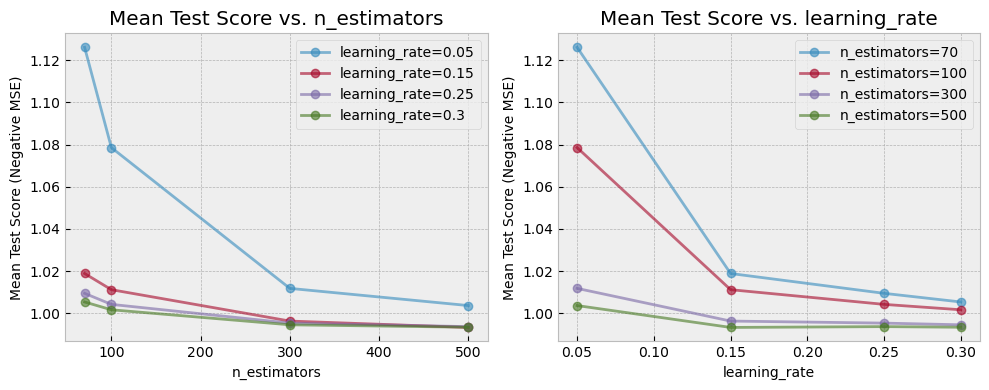

In [13]:
param1 = list(param_grid.keys())[0]
param2 = list(param_grid.keys())[1]
p1_name = param1.split("__")[1]
p2_name = param2.split("__")[1]

# Extract the relevant information for plotting vs the max_depth parameter
mean_test_scores_depth = np.sqrt(
    -grid_search.cv_results_["mean_test_score"].reshape(len(param_grid[param1]), -1)
)
p2_values = param_grid[param2]

# Extract the relevant information for plotting vs the n_estimators parameter
mean_test_scores_estimators = np.sqrt(
    -grid_search.cv_results_["mean_test_score"].reshape(len(param_grid[param1]), -1)
).T
p1_values = param_grid[param1]

# Start plot
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Plot a line for each max_depth value
for i, lr in enumerate(p1_values):
    ax[0].plot(
        p2_values,
        mean_test_scores_depth[i, :],
        label=f"{p1_name}={lr}",
        marker="o",
        alpha=0.6,
    )

ax[0].set_title(f"Mean Test Score vs. {p2_name}")
ax[0].set_xlabel(f"{p2_name}")
ax[0].set_ylabel("Mean Test Score (Negative MSE)")
ax[0].legend(prop={"size": 10})
ax[0].grid(True)

# Plot a line for each n_estimators value
for i, n_est in enumerate(p2_values):
    ax[1].plot(
        p1_values,
        mean_test_scores_estimators[i, :],
        label=f"{p2_name}={n_est}",
        marker="o",
        alpha=0.6,
    )

ax[1].set_title(f"Mean Test Score vs. {p1_name}")
ax[1].set_xlabel(f"{p1_name}")
ax[1].set_ylabel("Mean Test Score (Negative MSE)")
ax[1].legend(prop={"size": 10})
ax[1].grid(True)

plt.tight_layout()
plt.show()

## Prediction visualization

In [14]:
rmse_per_counter = []

for c in X_test["counter_name"].unique():
    # Filter predictions and actual values based on the counter
    y_hat_counter = y_hat[X_test["counter_name"] == c]
    y_test_counter = y_test[X_test["counter_name"] == c]

    # Calculate RMSE for the current counter
    rmse = mean_squared_error(y_test_counter, y_hat_counter, squared=False)

    # Store results in the list
    rmse_per_counter.append({"Counter": c, "Test set RMSE": rmse})

# Convert the list to a DataFrame
rmse_per_counter = pd.DataFrame(rmse_per_counter)

# Sort the DataFrame based on the "Counter" column
rmse_per_counter = rmse_per_counter.sort_values(by="Test set RMSE", ascending=False)

# Print the sorted table
print(rmse_per_counter)

                                            Counter  Test set RMSE
52                        20 Avenue de Clichy NO-SE       1.847377
53                        20 Avenue de Clichy SE-NO       1.692335
50                           90 Rue De Sèvres NE-SO       1.139131
51                           90 Rue De Sèvres SO-NE       1.028492
40                                 Quai d'Orsay E-O       0.746874
47                         Totem Cours la Reine O-E       0.737288
46                         Totem Cours la Reine E-O       0.726262
24                          Pont de la Concorde S-N       0.723509
42                    27 quai de la Tournelle NO-SE       0.681407
32                        36 quai de Grenelle NE-SO       0.663884
35                     Face au 40 quai D'Issy SO-NE       0.661045
54                       254 rue de Vaugirard NE-SO       0.648736
34                     Face au 40 quai D'Issy NE-SO       0.631437
13                     Face au 70 quai de Bercy N-S       0.62

Plot predictions for counters with worst residuals

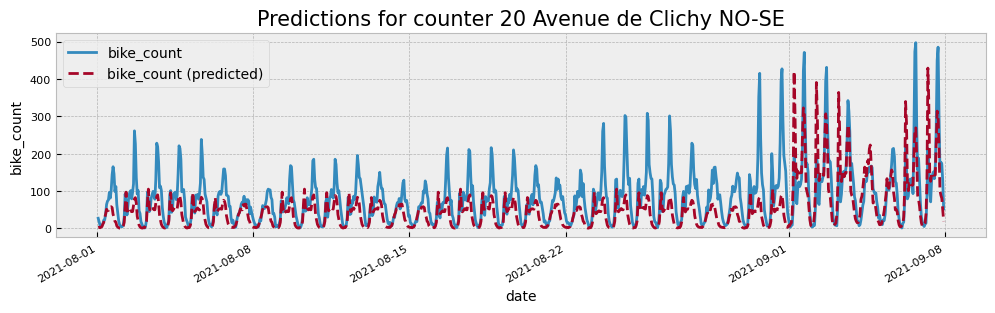

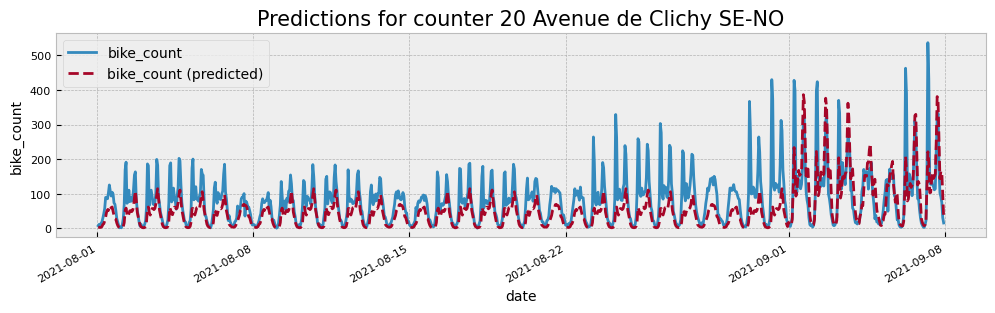

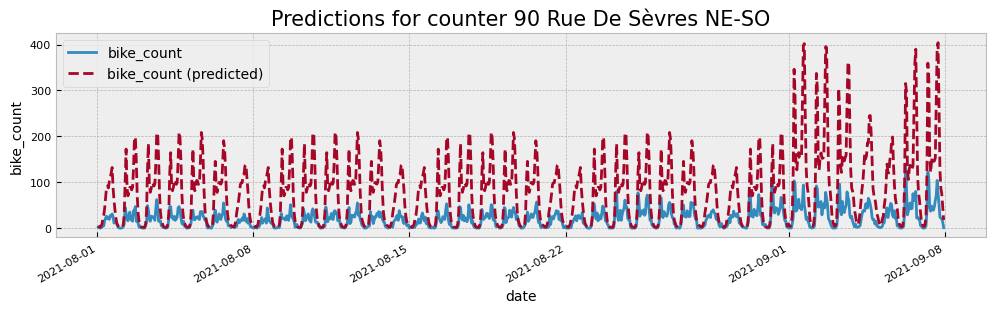

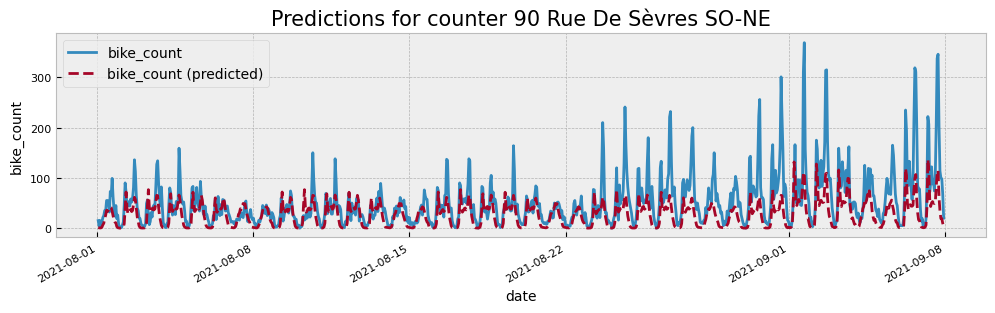

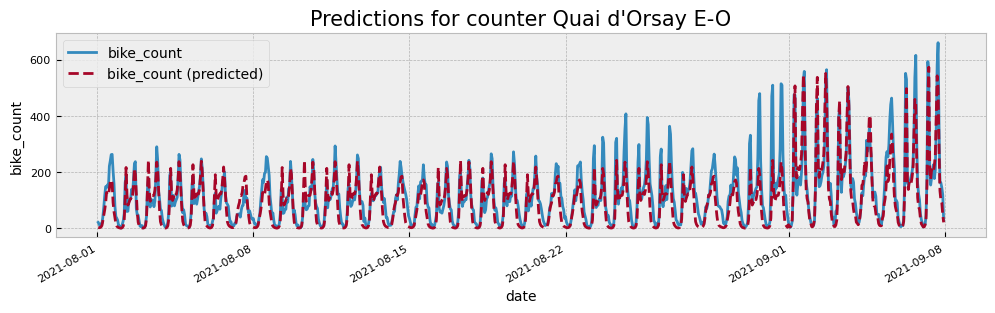

In [15]:
for c in rmse_per_counter["Counter"].iloc[:5]:
    mask = (
        (X_test["counter_name"] == c)
        & (X_test["date"] > pd.to_datetime("2021/08/01"))
        & (X_test["date"] < pd.to_datetime("2021/09/08"))
    )

    df_viz = X_test.loc[mask].copy()
    df_viz["bike_count"] = np.exp(y_test[mask.values]) - 1
    df_viz["bike_count (predicted)"] = np.exp(best_model.predict(X_test[mask])) - 1

    fig, ax = plt.subplots(figsize=(12, 3))

    df_viz.plot(x="date", y="bike_count", ax=ax)
    df_viz.plot(x="date", y="bike_count (predicted)", ax=ax, ls="--")
    ax.set_title(f"Predictions for counter {c}", fontsize=15)
    ax.set_ylabel("bike_count")
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.show()